# Portfolio Diversification

In [2]:
sys.path.insert(0,'/Users/danieljacobsen/Dropbox/Cand.merc.mat/3. semester/Python for the financial economist/Eksamen/ExamPython')


In [3]:
"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag
from scipy.stats import entropy

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
from codelib.portfolio_optimization.diversification import calculate_enc

from codelib.visualization.base import correlation_plot, fan_chart

from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance

In [4]:
# Loading data

reader = FamaFrenchReader("49_Industry_Portfolios", start=datetime.datetime(1970, 1, 1))
data = reader.read()

# Printing description
data['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202210 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (634 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (634 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (52 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (52 rows x 49 cols)\n  4 : Number of Firms in Portfolios (634 rows x 49 cols)\n  5 : Average Firm Size (634 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (53 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (53 rows x 49 cols)'

In [53]:
# get market cap weighted returns
mc_weighted = data[0] / 100
mc_weighted.columns = mc_weighted.columns.str.strip()

# get number of companies in each sector
num_companies = data[4]
num_companies.columns = num_companies.columns.str.strip()

# get average firm size 
avg_firm_size = data[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

In [132]:
sector_mkt_cap_relative["Other"]["1973-07"]

0.04433194939993591

In [54]:
sector_mkt_cap_relative.T.nlargest(5,"2022-10")

Date,1970-01,1970-02,1970-03,1970-04,1970-05,1970-06,1970-07,1970-08,1970-09,1970-10,...,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
Softw,0.000027,0.000020,0.000023,0.000021,0.000015,0.000011,0.000321,0.000264,0.000225,0.000373,...,0.192113,0.186376,0.178625,0.177274,0.169851,0.164185,0.169171,0.166540,0.164445,0.159362
Chips,0.028927,0.028084,0.028337,0.027195,0.024929,0.023200,0.021768,0.021690,0.022691,0.023497,...,0.115851,0.114296,0.114079,0.115851,0.111099,0.110241,0.105833,0.113248,0.111041,0.107179
Rtail,0.053097,0.054096,0.054237,0.053943,0.054067,0.052346,0.053448,0.055233,0.055377,0.056580,...,0.085099,0.082236,0.082904,0.083129,0.081283,0.077146,0.072253,0.076757,0.076927,0.078297
Drugs,0.046568,0.047307,0.047392,0.045337,0.045778,0.045263,0.046934,0.044769,0.043383,0.044669,...,0.059098,0.058347,0.058161,0.060270,0.063663,0.065310,0.072009,0.065805,0.064614,0.070844
Banks,0.017312,0.017304,0.018988,0.018703,0.018588,0.018646,0.021084,0.020943,0.021291,0.020170,...,0.070662,0.076265,0.076601,0.070559,0.071126,0.073907,0.068914,0.068196,0.068376,0.068364


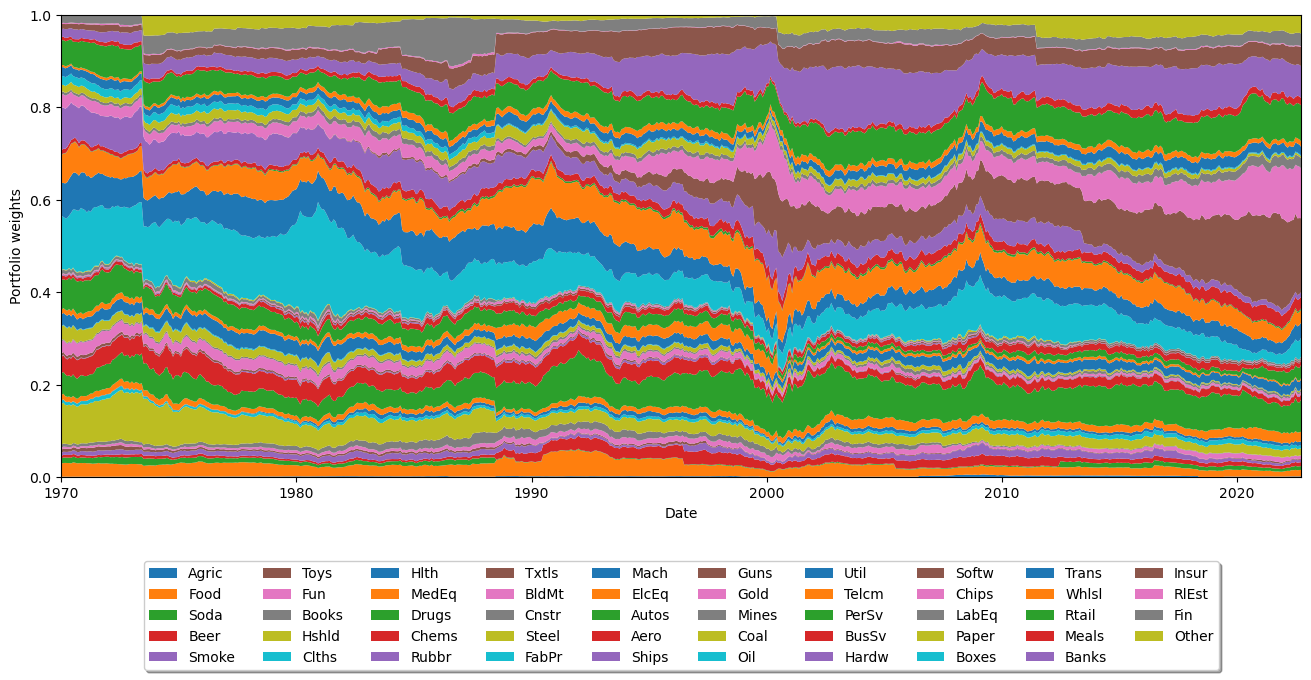

In [94]:
# Development of the market cap weights over time
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(sector_mkt_cap_relative.index.to_timestamp(), sector_mkt_cap_relative.T.values, labels=sector_mkt_cap_relative.columns);
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio weights")
ax.margins(x=0)
ax.set_ylim([0,1])
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=10);


In [56]:
#Calculates the effective number of constituents (ENC)

ENC1 = calculate_enc(weights=sector_mkt_cap_relative.T,alpha=1)

ENC2 = 1/np.square(sector_mkt_cap_relative).sum(axis=1)

#Concatenating the two dataframes:
ENC = pd.concat([pd.DataFrame(ENC1).set_index(ENC2.index), ENC2],axis=1)

#Defining column names
ENC.columns=["ENC1","ENC2"]

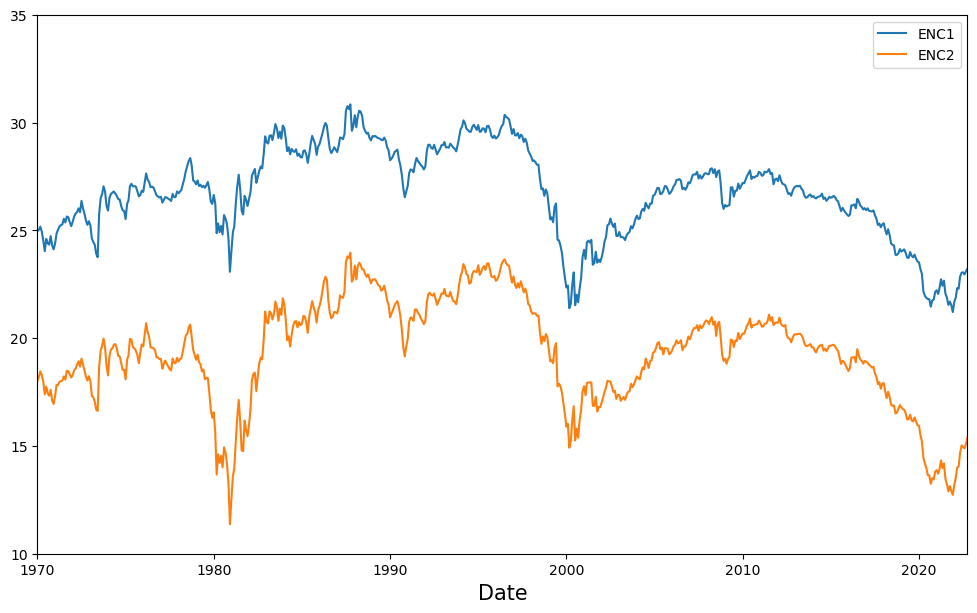

In [57]:
#Plotting development 

fig, ax = plt.subplots(figsize=(12,7))

#Choosing ENC
ax.plot(ENC.index.to_timestamp(),ENC.values)

#Adding legends
ax.legend(["ENC1","ENC2"])

#Adjusting y-axis and x-axis
ax.set_ylim([10,35])
ax.margins(x=0)

#Adding name for x-axis
plt.xlabel('Date', size=15);

In [101]:
# Relative risk contributions over time for investment strategy that allocates equally to the 
# industry portfolios

#returns
returns = mc_weighted

# Calculating covariance matrix:
cov_matrix_mc = returns.cov()

# Calculating covariance matrix:
corr_matrix_mc = returns.corr()

# Calculate vector of volatilities
vol_matrix_mc = np.diagonal(cov_matrix_mc)

# asset list
asset_list = mc_weighted.columns

In [102]:
# function to check if matrix is positive definite
def check_positive_semi_definite_eig(matrix: np.ndarray): 
    
    """
    Checks that a symmetric square matrix is positive semi-deinite. 
    
    Parameters
    ----------
    
    matrix: 
        Symmetric, Square matrix. 
        
    
    Returns
    -------
    bool
        Boolean indicating whether the matrix is positive semi-definite
        
    """
    
    return np.all(np.linalg.eigvals(matrix) >= 0)

In [103]:
# Checks if the covariance matrix is positive semi definit
print(check_positive_semi_definite_eig(cov_matrix_mc))
print(check_positive_semi_definite_eig(corr_matrix_mc))

True
True


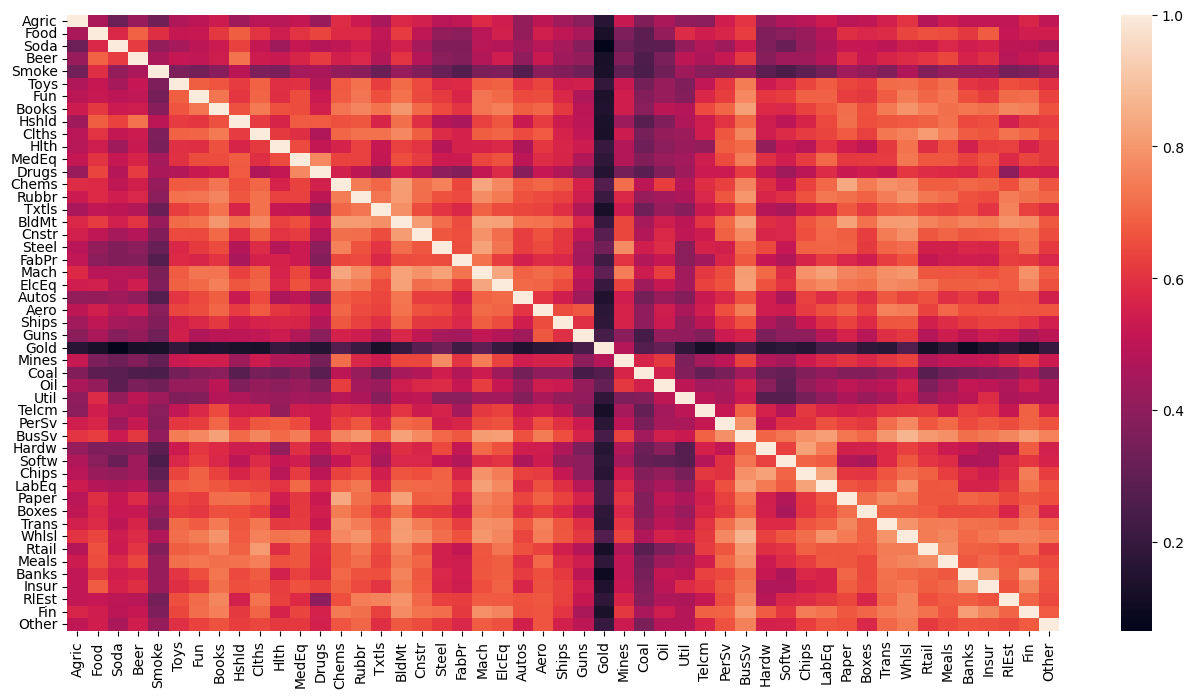

In [104]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr_matrix_mc, xticklabels=asset_list, yticklabels=asset_list);


In [61]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_mat: np.ndarray) -> np.ndarray:
    """
    Function that calculates marginal risk using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    total_risk = np.sqrt(weights @ cov_mat @ weights)
    inner_derivative = cov_mat @ weights

    return inner_derivative / total_risk


In [62]:
M = 60
relative_risk_contribution_ten_y = returns[M-1:].T.copy()
for i in range(len(returns.values[M-1:])):
    #10 years of data
    ten_y_ret = returns[i:i+M-1].copy()

    #Estimate covariance
    ten_y_cov = ten_y_ret.cov()

    #weights
    ten_y_weights = np.ones(49)/49

    #relative risk contribution
    rel_risk_contrib = calculate_risk_contributions_std(ten_y_weights, ten_y_cov, scale=True)


    relative_risk_contribution_ten_y.T[i:i+1]=rel_risk_contrib


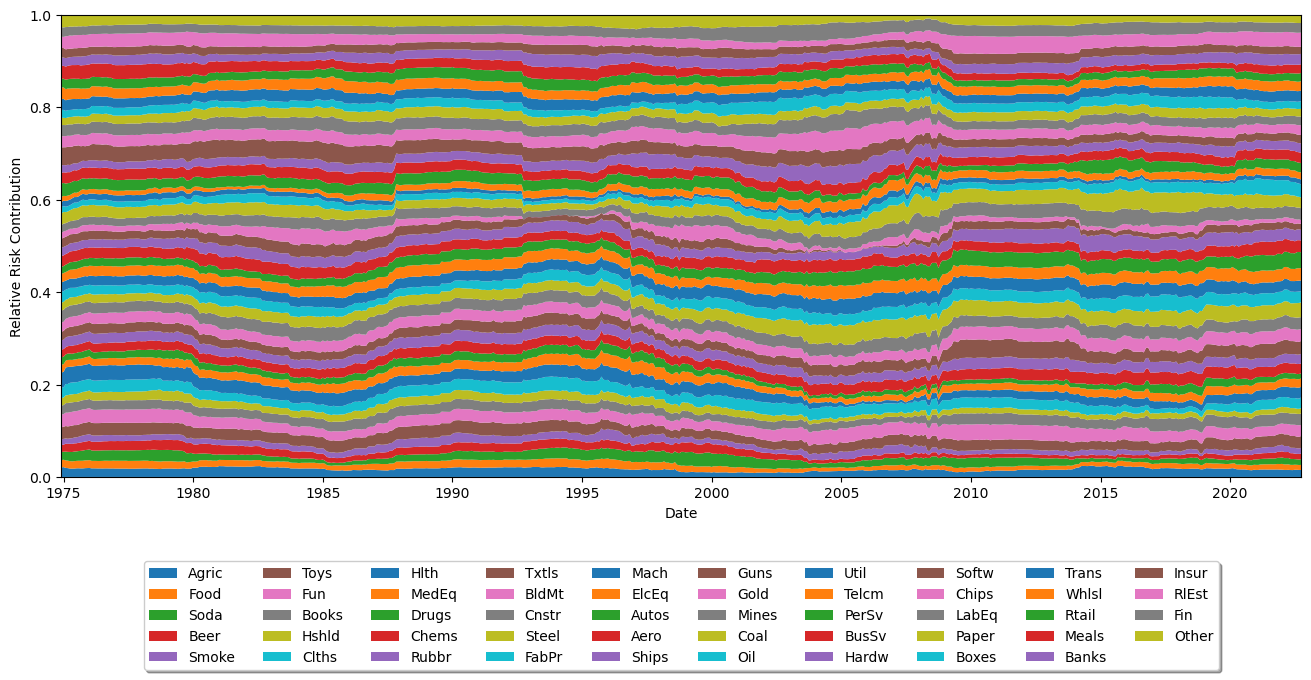

In [63]:
#Relative risk contribution over time
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(relative_risk_contribution_ten_y.T.index.to_timestamp(), relative_risk_contribution_ten_y.values, labels=asset_list);
ax.set_xlabel("Date")
ax.set_ylabel("Relative Risk Contribution")
ax.set_ylim(0,1)
ax.margins(x=0)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=10);




In [64]:
# Choueifaty and Coignard
def CC(weights: np.ndarray, cov_mat: np.ndarray) -> np.ndarray:
   
    vol = np.sqrt(np.diagonal(cov_mat))

    total_risk = np.sqrt(weights @ cov_mat @ weights)
    wv = weights @ vol

    return wv / total_risk

In [65]:
M = 60
cc_ten_y = list()
for i in range(len(returns.values[M-1:])):
    #10 years of data
    ten_y_ret = returns[i:i+M-1].copy()

    #Estimate covariance
    ten_y_cov = ten_y_ret.cov()

    #Estimate vol
    ten_y_vol = np.diagonal(ten_y_cov)

    #weights
    ten_y_weights = np.ones(49)/49

    #relative risk contribution
    rel_risk_contrib = CC(ten_y_weights, ten_y_cov)


    cc_ten_y.append(rel_risk_contrib)

cc_ten_y = pd.DataFrame(cc_ten_y).set_index(mc_weighted.index[M-1:])

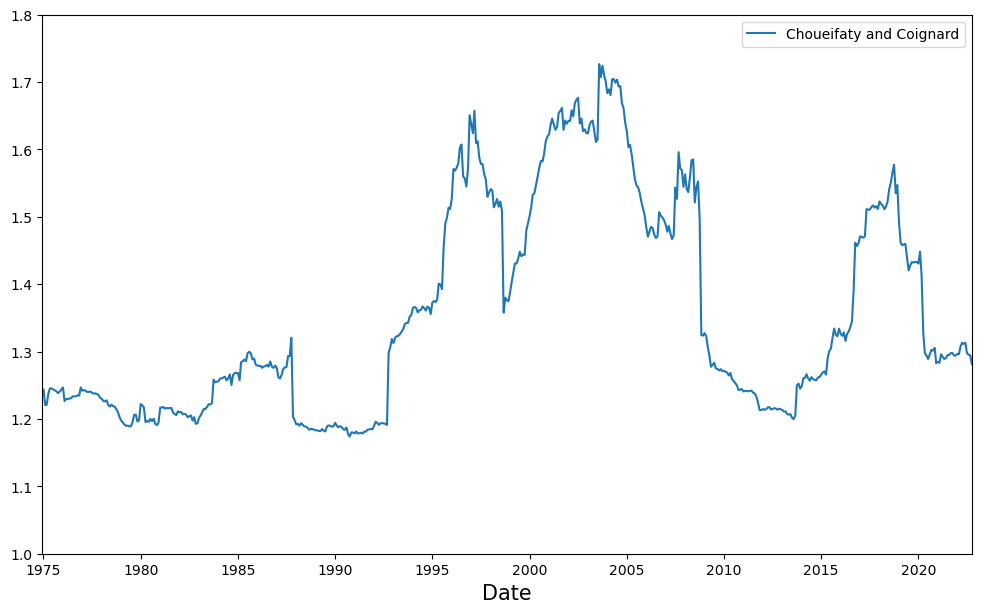

In [66]:
#Plotting over time

fig, ax = plt.subplots(figsize=(12,7))

#Choosing ENC
ax.plot(cc_ten_y.index.to_timestamp(),cc_ten_y.values)

#Adding legends
ax.legend(["Choueifaty and Coignard"])

#Adjusting y-axis and x-axis
ax.set_ylim([1,1.8])
ax.margins(x=0)

#Adding name for x-axis
plt.xlabel('Date', size=15);

In [67]:
#Setting up optimization problems

#Defining constraints:
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0,
                  'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x ,
                 'jac' : lambda x: np.eye(len(x))}

In [68]:
# Choueifaty and Coignard
def CC_negative(weights: np.ndarray, cov_mat: np.ndarray) -> np.ndarray:
   
    vol = np.sqrt(np.diagonal(cov_mat))

    total_risk = np.sqrt(weights @ cov_mat @ weights)
    wv = weights @ vol

    return -wv / total_risk

In [69]:
M = 60
weights_cc = returns[M-1:].T.copy()
weights_min_var = returns[M-1:].T.copy()
for i in range(len(returns.values[M-1:])):
    #10 years of data
    ten_y_ret = returns[i:i+M-1].copy()

    #Estimate covariance
    ten_y_cov = ten_y_ret.cov()

    #Estimate vol
    ten_y_vol = np.diagonal(ten_y_cov)

    #weights
    ten_y_weights = np.ones(49)/49

    #Optimizing minimum variance pf:
    res_cc = optimize.minimize(CC_negative, x0=ten_y_weights, args=(ten_y_cov,),
                        method='SLSQP',
                        constraints=[sum_to_one_cons, no_short_cons],  # no_short_cons,
                        options={'ftol': 1e-9, 'disp': True}) #, bounds=bounds)

    w_opt_cc = res_cc.x

    weights_cc.T[i:i+1]=w_opt_cc

    #Optimizing minimum variance pf:
    res_min = optimize.minimize(portfolio_variance, x0=ten_y_weights, args=(ten_y_cov,),
                        method='SLSQP',
                        constraints=[sum_to_one_cons, no_short_cons],  # no_short_cons,
                        options={'ftol': 1e-9, 'disp': True}) #, bounds=bounds)

    w_opt_minimum_variance = res_min.x

    weights_min_var.T[i:i+1]=w_opt_minimum_variance


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5003562097994845
            Iterations: 15
            Function evaluations: 755
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0017418314064395338
            Iterations: 60
            Function evaluations: 3000
            Gradient evaluations: 60
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5092799592478856
            Iterations: 15
            Function evaluations: 753
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.001713978209027931
            Iterations: 66
            Function evaluations: 3300
            Gradient evaluations: 66
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4779871120940005
            Iterations: 14
          

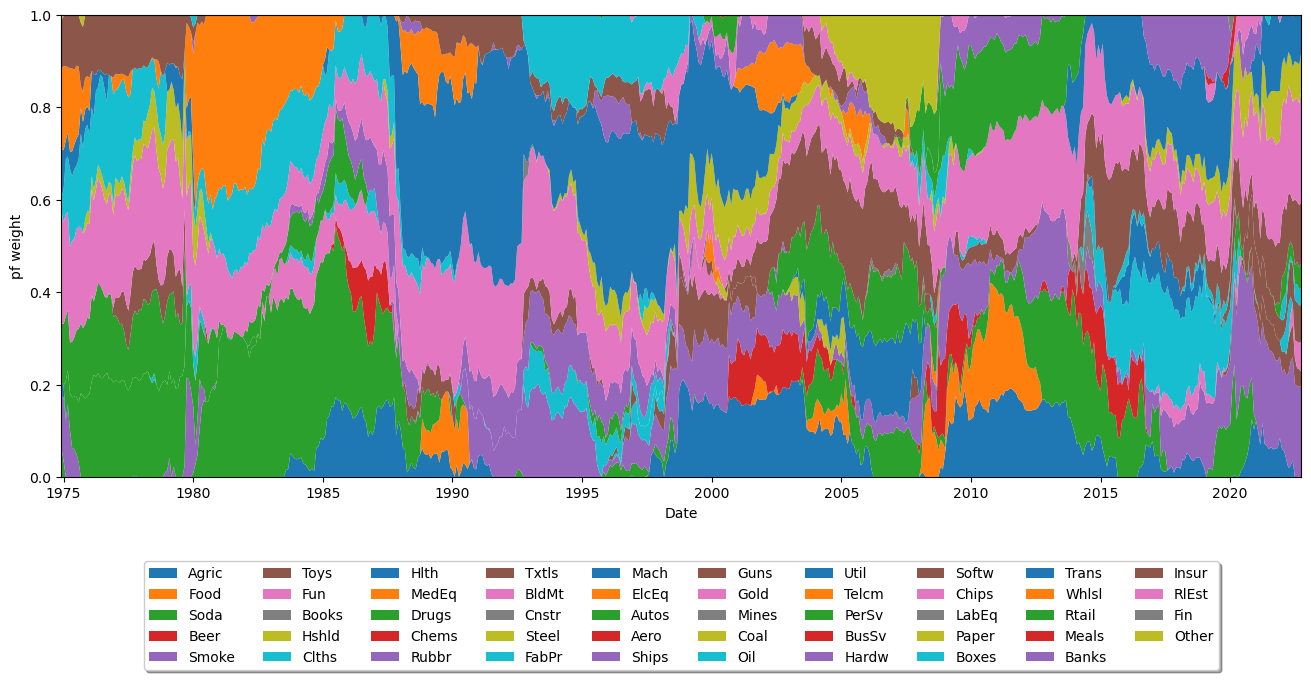

In [70]:
#CC plot
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(weights_cc.T.index.to_timestamp(), weights_cc.values, labels=asset_list);
ax.set_xlabel("Date")
ax.set_ylabel("pf weight")
ax.set_ylim(0,1)
ax.margins(x=0)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=10);



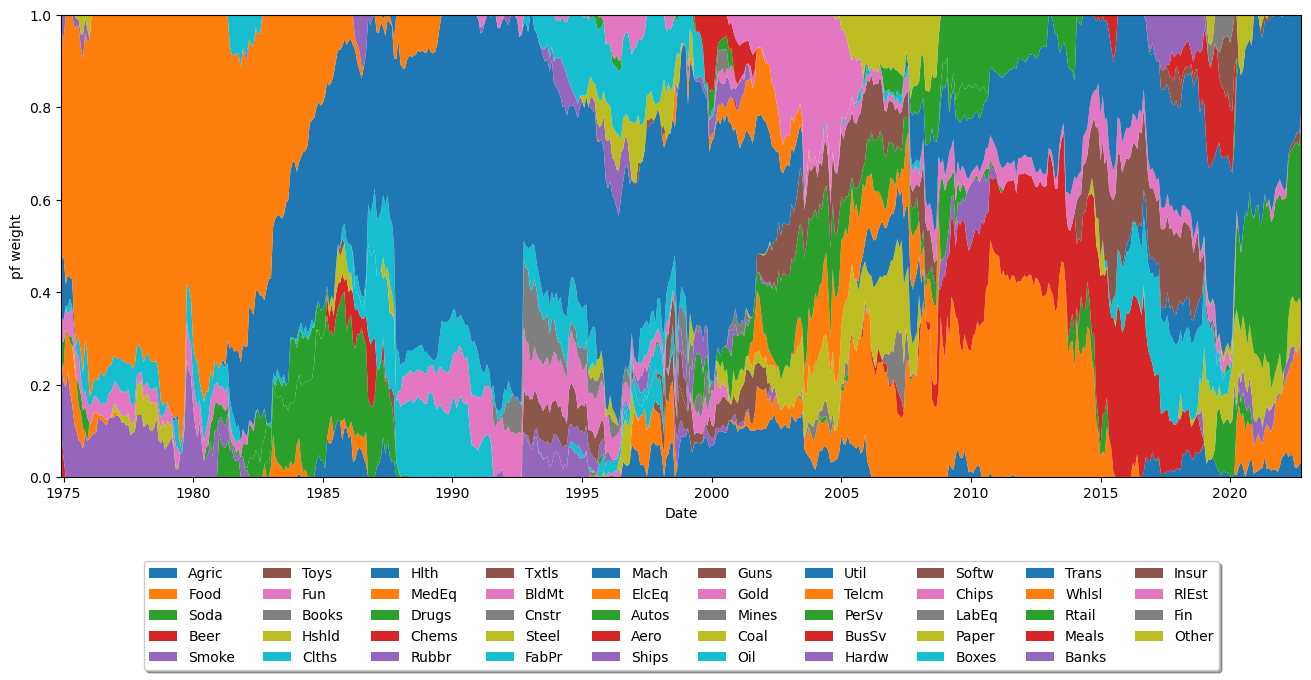

In [71]:
#Minimum variance plot
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(weights_min_var.T.index.to_timestamp(), weights_min_var.values, labels=asset_list);
ax.set_xlabel("Date")
ax.set_ylabel("pf weight")
ax.set_ylim(0,1)
ax.margins(x=0)
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=10);

In [72]:
M = 60
cc_ten_y_CC = list()
cc_ten_y_min_var = list()
for i in range(len(returns.values[M-1:])):
    #10 years of data
    ten_y_ret = returns[i:i+M-1].copy()

    #Estimate covariance
    ten_y_cov = ten_y_ret.cov()

    #Estimate vol
    ten_y_vol = np.diagonal(ten_y_cov)

    #weights
    ten_y_weights = weights_cc.T[i:i+1].values[0]
    ten_y_weights_min_var = weights_min_var.T[i:i+1].values[0]

    #relative risk contribution
    rel_risk_contrib = CC(ten_y_weights, ten_y_cov)
    rel_risk_contrib_min_var = CC(ten_y_weights_min_var, ten_y_cov)


    cc_ten_y_CC.append(rel_risk_contrib)
    cc_ten_y_min_var.append(rel_risk_contrib_min_var)

cc_ten_y_CC = pd.DataFrame(cc_ten_y_CC).set_index(mc_weighted.index[60-1:])
cc_ten_y_min_var = pd.DataFrame(cc_ten_y_min_var).set_index(mc_weighted.index[60-1:])

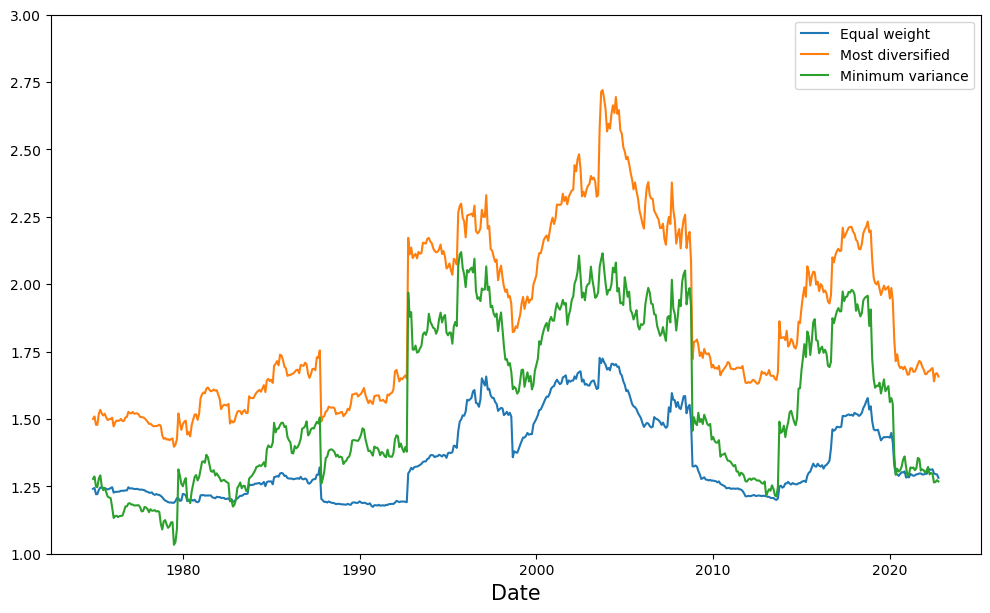

In [133]:
#Plotting CC risk measure for 3x pf over time

fig, ax = plt.subplots(figsize=(12,7))

#Choosing ENC
ax.plot(cc_ten_y.index.to_timestamp(),cc_ten_y.values)
ax.plot(cc_ten_y_CC.index.to_timestamp(),cc_ten_y_CC.values)
ax.plot(cc_ten_y_min_var.index.to_timestamp(),cc_ten_y_min_var.values)

#legend
ax.legend(["Equal weight","Most diversified","Minimum variance"])

#Adjusting y-axis
ax.set_ylim([1,3])

#Adding name for x-axis
plt.xlabel('Date', size=15);

In [125]:
#CC returns
cc_returns = np.multiply(mc_weighted[59:].T, weights_cc).sum(axis=0)

#min var returns
min_var_returns = np.multiply(mc_weighted[59:].T, weights_min_var).sum(axis=0)

#equally weighted returns
eq_returns = (mc_weighted[59:].T/49).sum(axis=0)

#cummulative returns
cc_cum_ret = ((cc_returns + 1).cumprod() - 1)
min_var_cum_ret = ((min_var_returns + 1).cumprod() - 1)
eq_cum_returns = ((eq_returns + 1).cumprod() - 1)

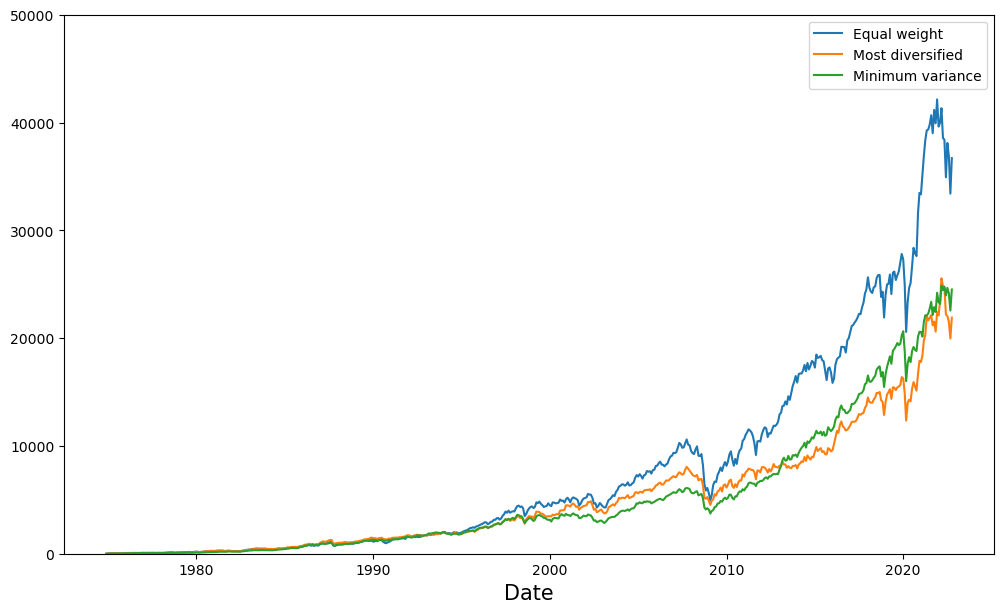

In [136]:
fig, ax = plt.subplots(figsize=(12,7))

#Choosing ENC
ax.plot(cc_returns.index.to_timestamp(), eq_cum_returns.values*100)
ax.plot(cc_returns.index.to_timestamp(),cc_cum_ret.values*100)
ax.plot(cc_returns.index.to_timestamp(),min_var_cum_ret.values*100)

#legend
ax.legend(["Equal weight","Most diversified","Minimum variance"])

#Adjusting y-axis
ax.set_ylim([-1,50000])

#Adding name for x-axis
plt.xlabel('Date', size=15);




In [91]:
#calculating the evaluation measures
five_y_data = mc_weighted[59:]


# annualized covariance matrix
cov_mat = five_y_data.cov().values * 12.0

#CC pf
# annualized hist. avg. returns
mu_cc = np.multiply(mc_weighted[59:].T, np.array(weights_cc)).sum(axis=0).mean()*12
# standard deviation
sd_cc = np.std(np.multiply(mc_weighted[59:].T, np.array(weights_cc)).sum(axis=0),ddof=1)*np.sqrt(12)
# Information ratio
ir_cc = mu_cc / sd_cc

#Min_var pf
# annualized hist. avg. returns
mu_min_var = np.multiply(mc_weighted[59:].T, np.array(weights_min_var)).sum(axis=0).mean()*12
# standard deviation
sd_min_var = np.std(np.multiply(mc_weighted[59:].T, np.array(weights_min_var)).sum(axis=0),ddof=1)*np.sqrt(12)
# Information ratio
ir_min_var = mu_min_var / sd_min_var

#EQ weighted pf
#weights:
weights_eq = pd.DataFrame(np.ones([49,575])/49)
weights_eq =weights_eq.set_index(weights_cc.index)
weights_eq.columns=weights_cc.columns
# annualized hist. avg. returns
mu_eq = (mc_weighted[59:]/49).sum(axis=1).mean()*12
# standard deviation
sd_eq = np.std(np.multiply(mc_weighted[59:].T, np.array(weights_eq)).sum(axis=0),ddof=1)*np.sqrt(12)
# Information ratio
ir_eq = mu_eq / sd_eq

print("Average returns")
print(mu_cc, mu_min_var, mu_eq)
print("Std")
print(sd_cc, sd_min_var, sd_eq)
print("Information ratio")
print(ir_cc, ir_min_var, ir_eq)

Average returns
0.12427776964008735 0.12289591143678244 0.13817998935226278
Std
0.14909933821617943 0.12165679199894301 0.16778146506536756
Information ratio
0.8335232813702819 1.0101853699861674 0.8235712407114095


In [92]:
# Turn-over calculation
def turnover(weights: np.ndarray, asset_returns: np.ndarray) -> float:
    """
    Function that calculates the tuen-over of a portfolio
    """
    T_OOS = len(weights)

    w_tilde = np.multiply(asset_returns[1:]+1, np.array(weights[:-1])).T/((1+asset_returns[1:].mean(axis=1)).values)

    value = (1/(T_OOS-1))*(np.abs((w_tilde.T-weights[1:])).sum().sum())

    return value

In [93]:
#calculating turnover:
cc_turn = turnover(weights_cc.T,mc_weighted[59:])*12

min_var_turn =turnover(weights_min_var.T,mc_weighted[59:])*12

weights_eq = pd.DataFrame(np.ones([49,575])/49)
weights_eq =weights_eq.set_index(weights_cc.index)
weights_eq.columns=weights_cc.columns

eq_turn = turnover(weights_eq.T,mc_weighted[59:])*12


print("CC=", cc_turn , " min var = ", min_var_turn, " eq = ", eq_turn)

CC= 1.7572166428183598  min var =  1.7723753843396033  eq =  0.3835061455241239
